<a href="https://colab.research.google.com/github/bhavya220702/Correlated-stock/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!pip install --upgrade --force-reinstall --no-deps torch
!pip install --upgrade --force-reinstall --no-deps torchvision
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [5]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from tqdm import tqdm
import time
import copy
import timm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import timm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
ROOT_PATH = "/content/drive/MyDrive/Covid19-dataset/"

In [7]:
train_dir = os.path.join(ROOT_PATH, 'train')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

train_covid_fnames = os.listdir(train_covid_dir)
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_covid_fnames[:10])
print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])

['010.png', '021.jpeg', '015.jpg', '01.jpeg', '02.jpeg', '022.jpeg', '012.jpeg', '019.png', '020.jpg', '024.jpeg']
['01.jpeg', '015.jpeg', '02.jpeg', '018.jpeg', '019.jpeg', '016.jpeg', '010.jpeg', '012.jpeg', '013.jpeg', '017.jpeg']
['010.jpeg', '01.jpeg', '011.jpeg', '021.jpeg', '023.jpeg', '041.jpeg', '044.jpeg', '025.jpeg', '034.jpeg', '036.jpeg']


covid_img_path_list ['/content/drive/MyDrive/Covid19-dataset/train/Covid/010.png', '/content/drive/MyDrive/Covid19-dataset/train/Covid/021.jpeg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/015.jpg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/01.jpeg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/02.jpeg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/022.jpeg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/012.jpeg', '/content/drive/MyDrive/Covid19-dataset/train/Covid/019.png']


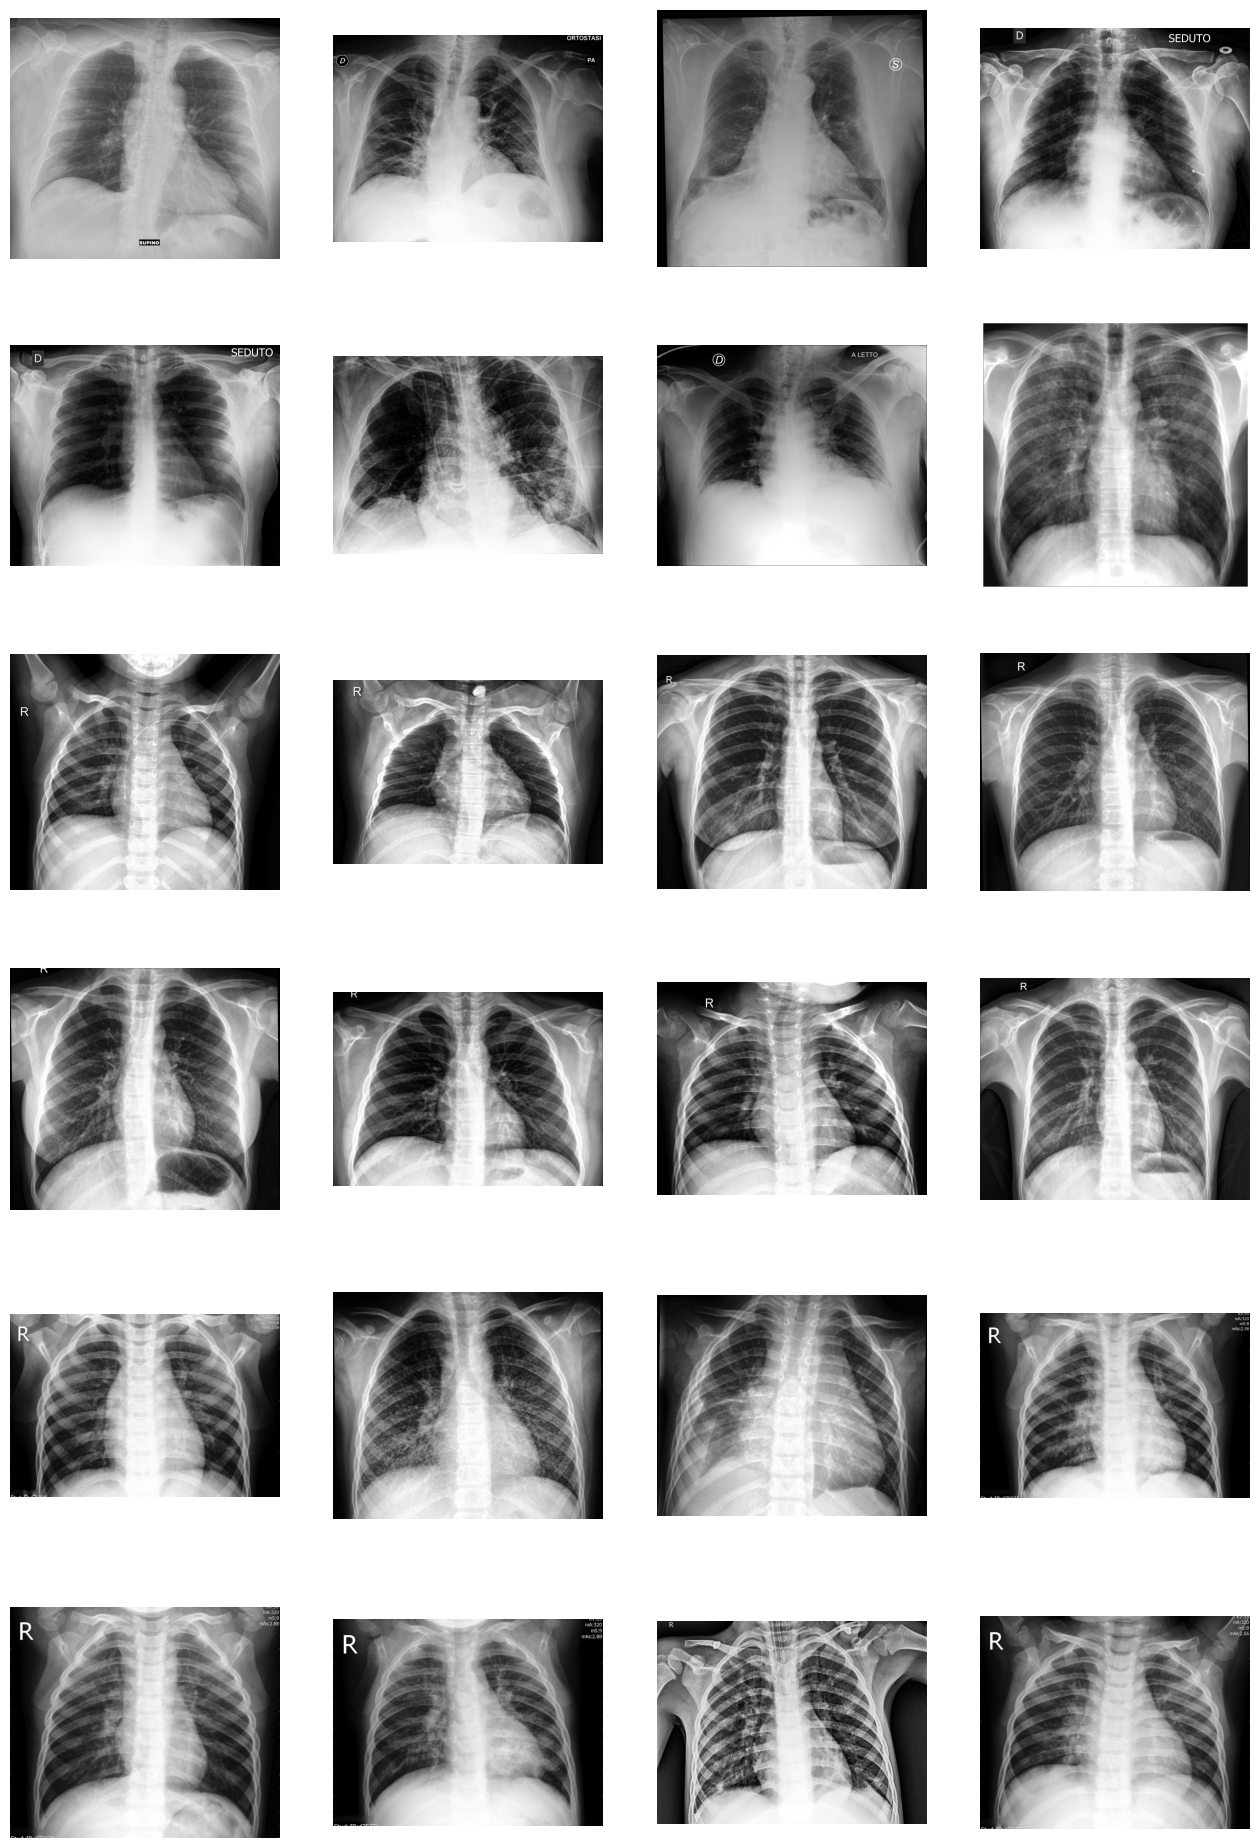

In [8]:
nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

covid_img_path_list = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] ]
print("covid_img_path_list", covid_img_path_list)


normal_img_list = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

pneumonia_img_list = [os.path.join(train_pneumonia_dir, fname) 
                for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(covid_img_path_list+normal_img_list+pneumonia_img_list):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
def get_dataset_loader(data_path, batch_size=256, train=False):
  if train:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), transforms.GaussianBlur(3)]), p=0.1),
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
      transforms.RandomErasing(p=0.12, value='random')
    ])

    train_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'), transform=transform)

    print(f"We have {len(train_imgs)} Training Images with {len(train_imgs.classes)} classes")

    len_train_images = int(len(train_imgs) * 0.78)
    
    len_validation_images = int(len(train_imgs) - len_train_images )

    train_dataset, validation_dataset = random_split(train_imgs, [len_train_images, len_validation_images] )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_dataloader, validation_dataloader, len(train_dataset), len(validation_dataset)

  else:
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
  ])
  
  test_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'test/'), transform=transform)
  
  print(f"We have {len(test_imgs)} Training Images with {len(test_imgs.classes)} classes")
  
  test_dataloader = DataLoader(test_imgs, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  
  return test_dataloader, len(test_imgs)
    

In [10]:
class_categories = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/')).classes
# ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(class_categories)
num_classes

3

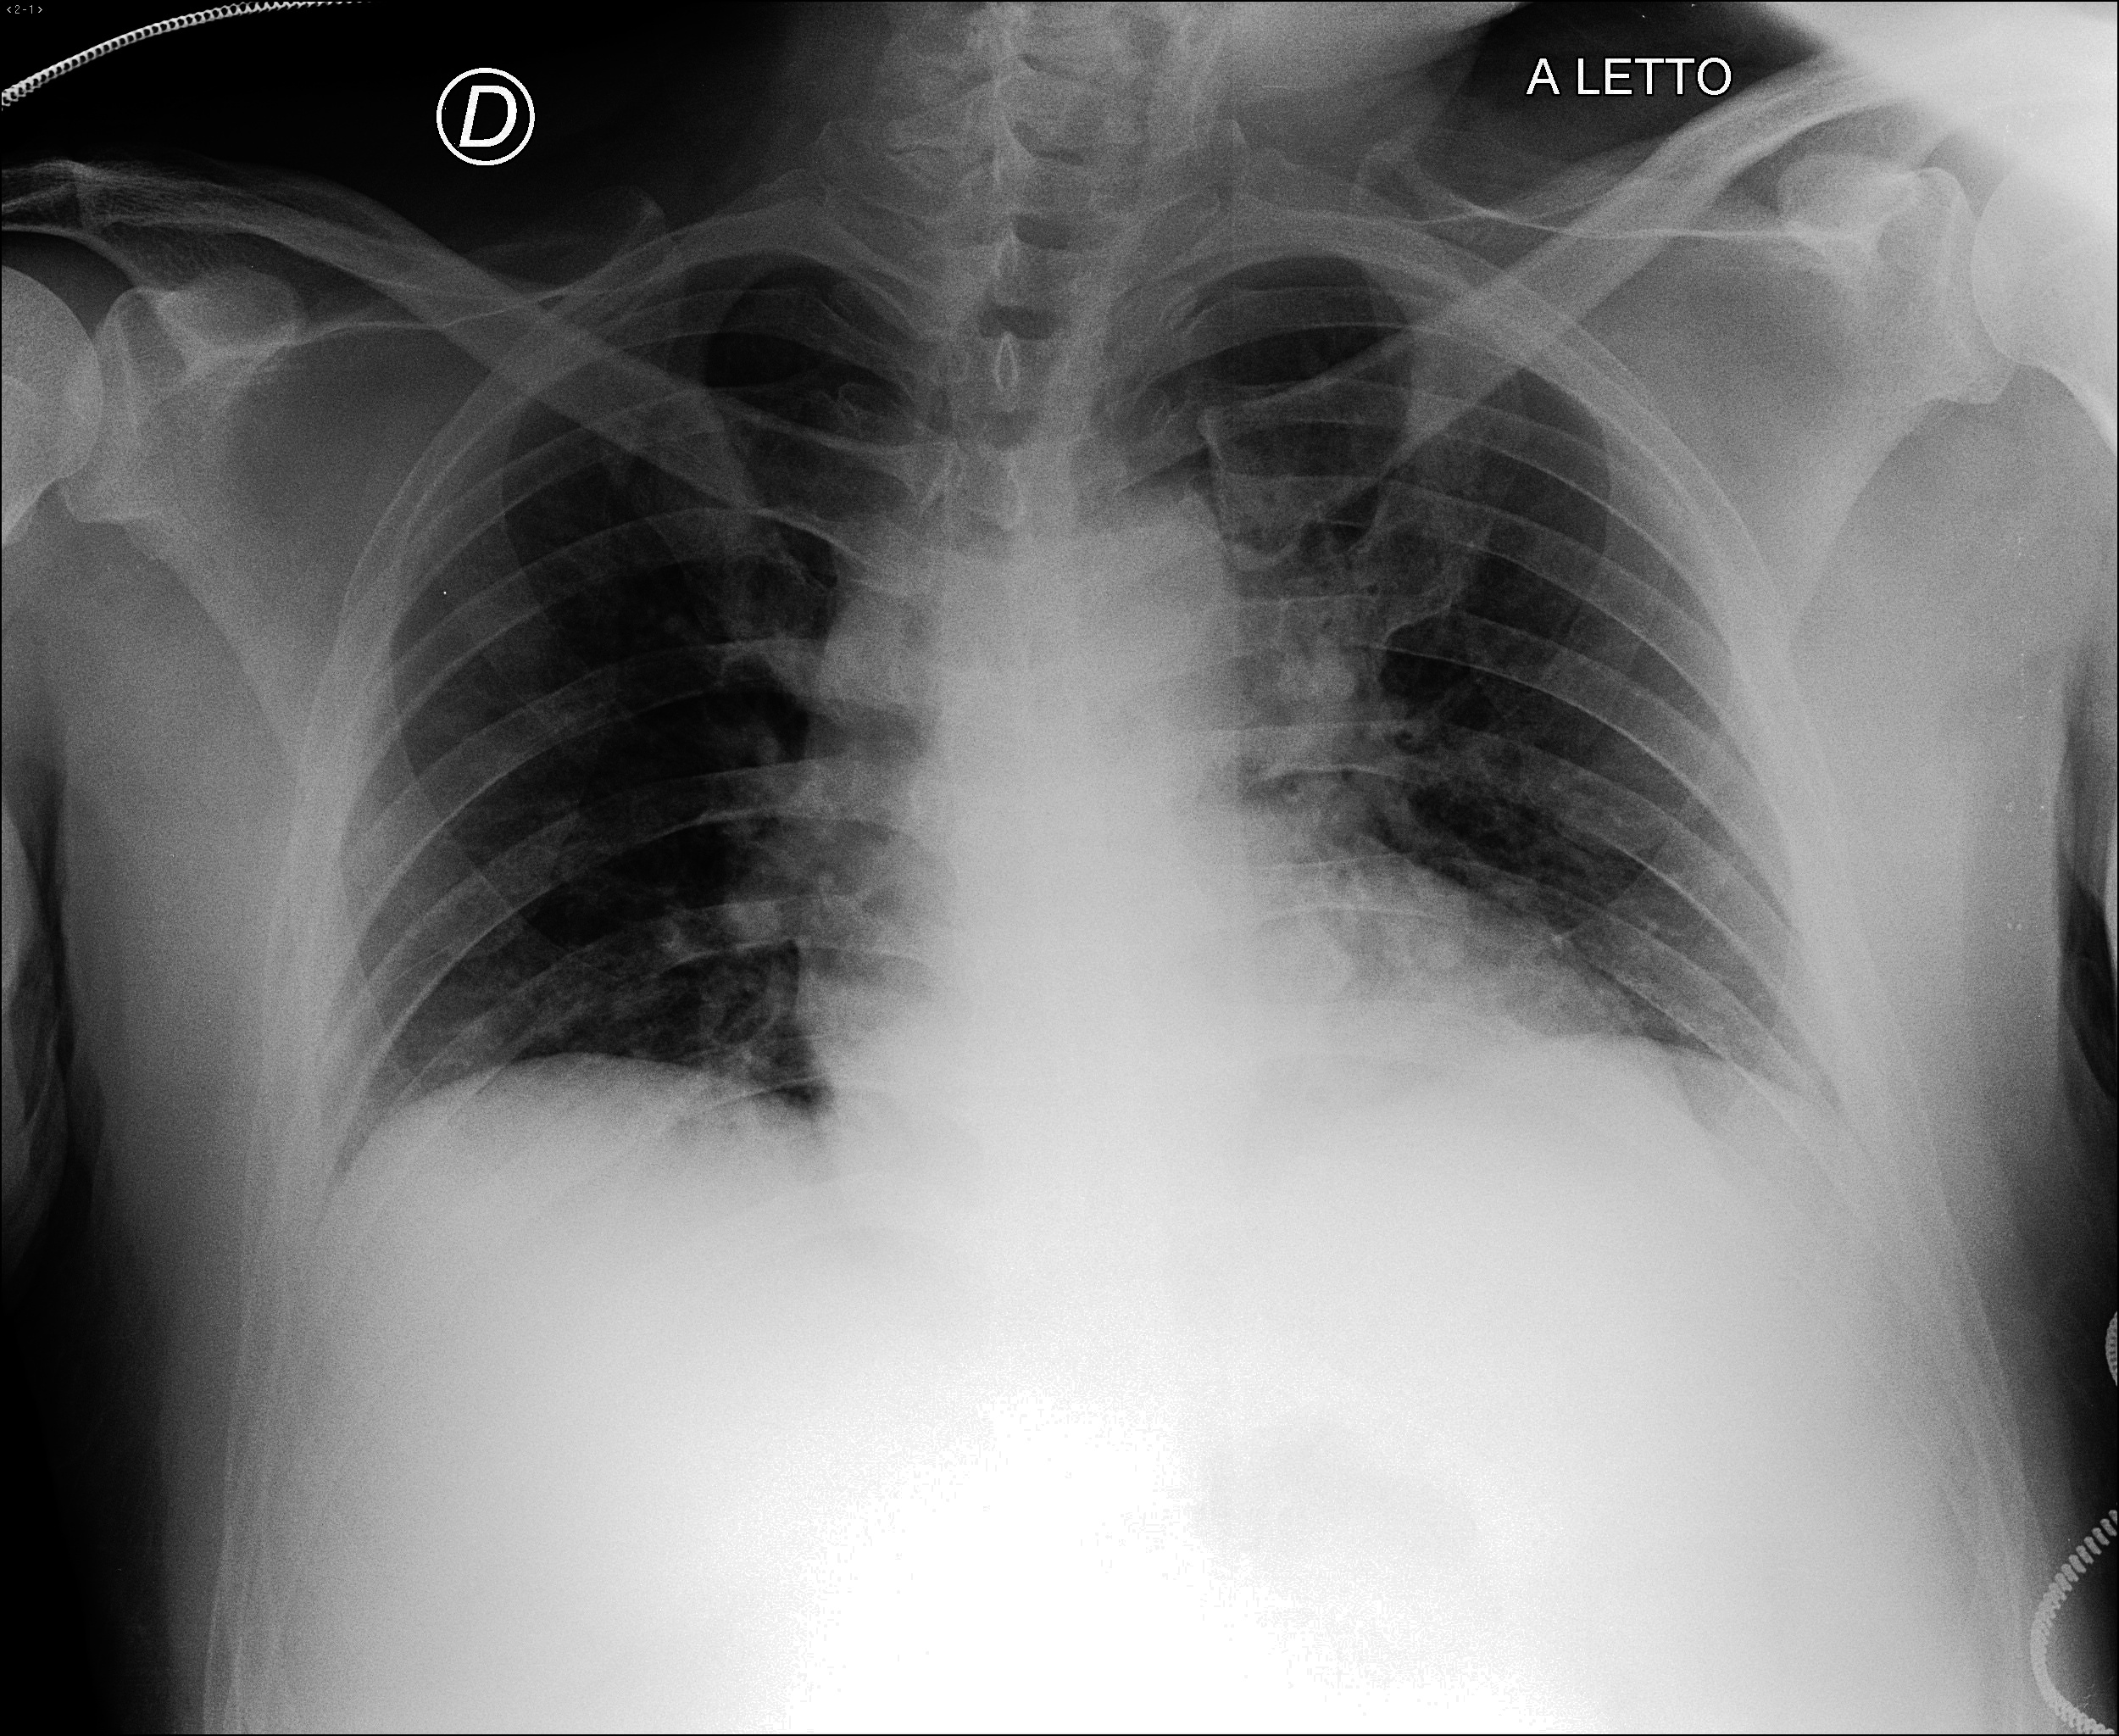

In [11]:
train_data = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'))
train_data[2][0]

In [12]:
BATCH_SIZE = 32

(train_dataloader, validation_dataloader, len_train_dataloader, len_validation_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=True)

(test_dataloader, len_test_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=False)

We have 251 Training Images with 3 classes
We have 66 Training Images with 3 classes


In [13]:
train_dataloader.dataset

In [14]:
test_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/Covid19-dataset/test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.466), std=(0.229, 0.224, 0.255))
           )

In [15]:
print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))
print(len_train_dataloader, len_validation_dataloader, len_test_dataloader )

7
2
3
195 56 66


In [16]:
dataloaders_dict = {
  'train': train_dataloader,
  'validation': validation_dataloader
}

dataset_sizes_dict = {
  'train':len_train_dataloader,
  'validation': len_validation_dataloader
}

In [17]:
for i, (inputs, labels) in enumerate(train_dataloader):
    print(inputs.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 3, 224, 224]) torch.Size([3])


labels list is  tensor([0, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0,
        1, 0, 2, 0, 0, 2, 2, 1])


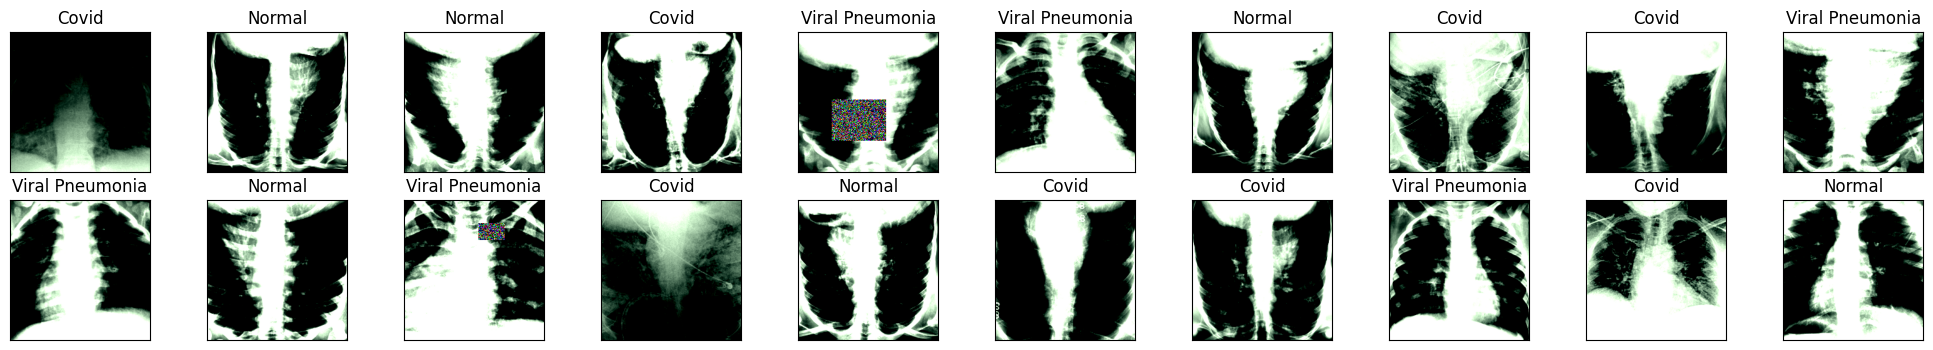

In [18]:
train_loader_iterable = iter(train_dataloader)

images, labels = next(train_loader_iterable)

print('labels list is ', labels)

# Now for displaying I have to convert images to Numpy
images = images.numpy()
# plt.imshow(images[1][1]) # this is will display this image

# Plot images in batch along with corresponding labels.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[] )
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  # in above line transpose should convert
  # a `[channel, height, width]` tensor to a `[height, width, channel]` one.
  
  ax.set_title(class_categories[labels[idx]])

In [19]:
torch.backends.cudnn.benchmark = True

model = models.efficientnet_b0(pretrained=True)

print("model.classifier is => ", model.classifier)

""" model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
"""

for param in model.parameters():
  param.requires_grad = False
  
num_inputs = model.classifier[1].in_features


""" Now here is where I am adding additional layers to the pre-trained model.

for nn.Linear - note the following
in_features – size of each input sample
out_features – size of each output sample

"""


model.classifier = nn.Sequential(
  nn.Linear(num_inputs, 2048),
  nn.SiLU(), # Sigmoid Weighted Linear Unit
  nn.Dropout(0.2),
  # Note that the last layer is 2048 * Number of Classes
  # Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
  nn.Linear(2048, len(class_categories))
)

model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 54.0MB/s]


model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=3, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001 )

In [21]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
# Change the learning rate based on number of epochs
# Decays the learning rate of each parameter group by gamma every step_size epochs

In [22]:
training_history = {'accuracy': [], 'loss':[] }
validation_history = {'accuracy': [], 'loss': []}

In [23]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
  start_time = time.time()
  
  best_model_weights = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  for epoch in range(num_epochs):
    print('Running epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    

    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0
      
 
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        
        
        with torch.set_grad_enabled(phase == 'train'):
          predicted_outputs = model(inputs)          
          
          _, predictions = torch.max(predicted_outputs, 1)

          loss = criterion(predicted_outputs, labels)
          
          
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        
      if phase == 'train':
        scheduler.step()      
      
      epoch_loss = running_loss / dataset_sizes_dict[phase]
      epoch_accuracy = running_corrects.double() / dataset_sizes_dict[phase]
      
      
      
      
      if phase == 'train':
        training_history['loss'].append(epoch_loss)
        training_history['accuracy'].append(epoch_accuracy)
      elif phase == 'validation':
        validation_history['loss'].append(epoch_loss)
        validation_history['accuracy'].append(epoch_accuracy)
        

      if phase == 'validation' and epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())
  
  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60
  ))
  print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
  
  model.load_state_dict(best_model_weights)
  return model

In [24]:
model_trained = train(model, criterion, optimizer, exp_lr_scheduler, num_epochs=150)

Running epoch 0/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


Running epoch 1/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


Running epoch 2/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Running epoch 3/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Running epoch 4/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Running epoch 5/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


Running epoch 6/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Running epoch 7/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


Running epoch 8/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Running epoch 9/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


Running epoch 10/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Running epoch 11/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Running epoch 12/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


Running epoch 13/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Running epoch 14/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Running epoch 15/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.63s/it]


Running epoch 16/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Running epoch 17/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Running epoch 18/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Running epoch 19/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Running epoch 20/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Running epoch 21/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Running epoch 22/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Running epoch 23/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Running epoch 24/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Running epoch 25/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Running epoch 26/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Running epoch 27/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


Running epoch 28/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Running epoch 29/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Running epoch 30/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Running epoch 31/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.99s/it]


Running epoch 32/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Running epoch 33/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Running epoch 34/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Running epoch 35/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


Running epoch 36/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


Running epoch 37/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


Running epoch 38/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Running epoch 39/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Running epoch 40/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Running epoch 41/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Running epoch 42/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Running epoch 43/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


Running epoch 44/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.18s/it]


Running epoch 45/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Running epoch 46/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Running epoch 47/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Running epoch 48/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Running epoch 49/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Running epoch 50/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Running epoch 51/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Running epoch 52/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Running epoch 53/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Running epoch 54/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Running epoch 55/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Running epoch 56/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Running epoch 57/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


Running epoch 58/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


Running epoch 59/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Running epoch 60/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Running epoch 61/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Running epoch 62/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


Running epoch 63/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Running epoch 64/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


Running epoch 65/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.00s/it]


Running epoch 66/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Running epoch 67/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Running epoch 68/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Running epoch 69/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.60s/it]


Running epoch 70/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


Running epoch 71/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Running epoch 72/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Running epoch 73/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Running epoch 74/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Running epoch 75/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Running epoch 76/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Running epoch 77/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Running epoch 78/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Running epoch 79/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


Running epoch 80/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Running epoch 81/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Running epoch 82/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Running epoch 83/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Running epoch 84/149
----------


100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


Running epoch 85/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Running epoch 86/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


Running epoch 87/149
----------


100%|██████████| 2/2 [00:11<00:00,  5.92s/it]


Running epoch 88/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


Running epoch 89/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Running epoch 90/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Running epoch 91/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Running epoch 92/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Running epoch 93/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.93s/it]


Running epoch 94/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


Running epoch 95/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Running epoch 96/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.46s/it]


Running epoch 97/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Running epoch 98/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Running epoch 99/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


Running epoch 100/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Running epoch 101/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.59s/it]


Running epoch 102/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Running epoch 103/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Running epoch 104/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Running epoch 105/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Running epoch 106/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Running epoch 107/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


Running epoch 108/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


Running epoch 109/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Running epoch 110/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Running epoch 111/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


Running epoch 112/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


Running epoch 113/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Running epoch 114/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


Running epoch 115/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Running epoch 116/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Running epoch 117/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


Running epoch 118/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


Running epoch 119/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Running epoch 120/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


Running epoch 121/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.81s/it]


Running epoch 122/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


Running epoch 123/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Running epoch 124/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Running epoch 125/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Running epoch 126/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Running epoch 127/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Running epoch 128/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Running epoch 129/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Running epoch 130/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Running epoch 131/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


Running epoch 132/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Running epoch 133/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Running epoch 134/149
----------


100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


Running epoch 135/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Running epoch 136/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Running epoch 137/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Running epoch 138/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Running epoch 139/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


Running epoch 140/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Running epoch 141/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


Running epoch 142/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Running epoch 143/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Running epoch 144/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Running epoch 145/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


Running epoch 146/149
----------


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Running epoch 147/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Running epoch 148/149
----------


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Running epoch 149/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.93s/it]

Training complete in 62m 30s
Best Validation Accuracy: 1.000000


In [25]:
def evaluate(model):
  loss_on_test_dataset = 0.0
  correct_class = list(0. for i in range(len(class_categories)))
  total_correct_for_all_classes = list(0. for i in range(len(class_categories)))
  
  model.eval()
  
  for test_inputs, test_labels in tqdm(test_dataloader):
    # In local machine, below 2 Lines will NOT work if local GPU
    # itself or the GPU's Compute Capability is NOT compatible with PyTorch
    if torch.cuda.is_available():
      test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()
    
    with torch.no_grad():
      output_test = model(test_inputs)
      loss = criterion(output_test, test_labels)
    
    loss_on_test_dataset += loss.item() * test_inputs.size(0)
    _, pred_test = torch.max(output_test, 1)
    
    """ 
    Now compare predictions to true label
    
    view_as => View this tensor as the same size as other. 
    self.view_as(other) is equivalent to self.view(other.size()).   
    tensor.view_as(other) is equivalent to tensor.view(other.size())
    """
    correct_tensor = pred_test.eq(test_labels.view_as(pred_test))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # Basically above will make sure if gpu is not available then we copy the tensor to cpu and convert it to numpy array.
    
    if len(test_labels) == BATCH_SIZE:
      for i in range(BATCH_SIZE):
        label = test_labels.data[i]
        correct_class[label] += correct[i].item() # updating corrects for each class object
        total_correct_for_all_classes[label] += 1 # updating corrects for total classes
        
  loss_on_test_dataset = loss_on_test_dataset/len(test_dataloader.dataset)
  print('Test Loss: {:.6f}\n'.format(loss_on_test_dataset))
  
  for i in range(len(class_categories)):
    if total_correct_for_all_classes[i] > 0:
      # Now print total Accuracy % and also number of corrects vs total number
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        class_categories[i], 100 * correct_class[i] / total_correct_for_all_classes[i],
        np.sum(correct_class[i]), np.sum(total_correct_for_all_classes[i])
      ))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (class_categories[i]))
  
  print('\n Test Accuracy (Overall): {:.4f} ({}/{})'.format(
    100 * np.sum(correct_class) / np.sum(total_correct_for_all_classes),
    np.sum(correct_class), np.sum(total_correct_for_all_classes)
  ))
    

In [26]:
evaluate(model_trained)

100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

Test Loss: 0.490255

Test Accuracy of Covid: 100% (26/26)
Test Accuracy of Normal: 85% (17/20)
Test Accuracy of Viral Pneumonia: 94% (17/18)

 Test Accuracy (Overall): 93.7500 (60.0/64.0)
